### Set autoreload

In [1]:
%load_ext autoreload
%autoreload 2

init_mesh_viewer = False

### Import Dependency

In [2]:
import torch
import numpy as np
import time
import h5py 
import random
import copy

from os import path as osp
import os
import glob

from scipy.spatial.transform import Rotation as R

import matplotlib.pyplot as plt

from body_visualizer.mesh.mesh_viewer import MeshViewer
from human_body_prior.tools.omni_tools import copy2cpu as c2c
from human_body_prior.body_model.body_model import BodyModel

from utils import plot_mesh, transform

os.environ['PYOPENGL_PLATFORM'] = 'egl' # for visualization in SSH

### Set directory path and other settings

In [3]:
h5py_dir = '/home/cotton_ahn/dataset/AMASS_h5py/'
smpl_dir = './body_models/smplx/'
bridge_str = '+++'
gender_list = ['neutral', 'female', 'male']

### Set device 

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### import random data from the h5py_dir.

In [5]:
hdf5_list = glob.glob(osp.join(h5py_dir, '*.hdf5'))
chosen_fp = random.choice(hdf5_list)
dataset = h5py.File(chosen_fp, 'r')
print('Import {}'.format(chosen_fp))

Import /home/cotton_ahn/dataset/AMASS_h5py/CMU.hdf5


In [6]:
dataset_keys = list(dataset.keys())
chosen_key = random.choice(dataset_keys)
chosen_motion = dataset[chosen_key]
print('Visualize "{}" action of subject "{}"'.format(chosen_key.split(bridge_str)[1], 
                                                            chosen_key.split(bridge_str)[0]))

Visualize "79_96" action of subject "79"


In [7]:
betas = chosen_motion['betas']
num_betas = len(betas)
poses = chosen_motion['poses'] # T by 165
trans = chosen_motion['trans'] # T by 3
gender = gender_list[np.asarray(chosen_motion['gender'])]
num_frames = len(trans)

print('Gender : {}, this motion has {} frames'.format(gender, num_frames))

Gender : male, this motion has 140 frames


### Define body model

In [8]:
bm_smplx_fname = osp.join(smpl_dir, '{}/model.npz'.format(gender))

bm = BodyModel(bm_fname=bm_smplx_fname, num_betas=num_betas).to(device)

faces = c2c(bm.f)
num_verts = bm.init_v_template.shape[1]

In [9]:
body_params = {'root_orient': torch.Tensor(poses[:, :3]),
               'pose_body': torch.Tensor(poses[:, 3:66]),
               'pose_hand': torch.Tensor(poses[:, 75:75+90]),
               'pose_jaw': torch.Tensor(poses[:, 66:69]),
               'pose_eye' : torch.Tensor(poses[:, 69:75]),
               'trans': torch.Tensor(trans),
               'betas': torch.Tensor(np.repeat(betas[:num_betas][np.newaxis], repeats=num_frames, axis=0)),
               }

# I don't know why but adding "pose_hand" makes the whole motion a little bit weird. This setting is recommended.
body = bm(**{k:v.to(device) for k,v in body_params.items() if k in ['pose_body', 
                                                                    'root_orient',
                                                                    'trans'
                                                                    ]})


### Start Plot

In [10]:
# run this cell only once. Otherwise it makes error. 
if not init_mesh_viewer:
    imw, imh = 640, 480
    mv = MeshViewer(imw, imh)
    mv.set_cam_trans([0, 1, 4])
    init_mesh_viewer = True

### Plot mesh - without any rotation

<IPython.core.display.Javascript object>


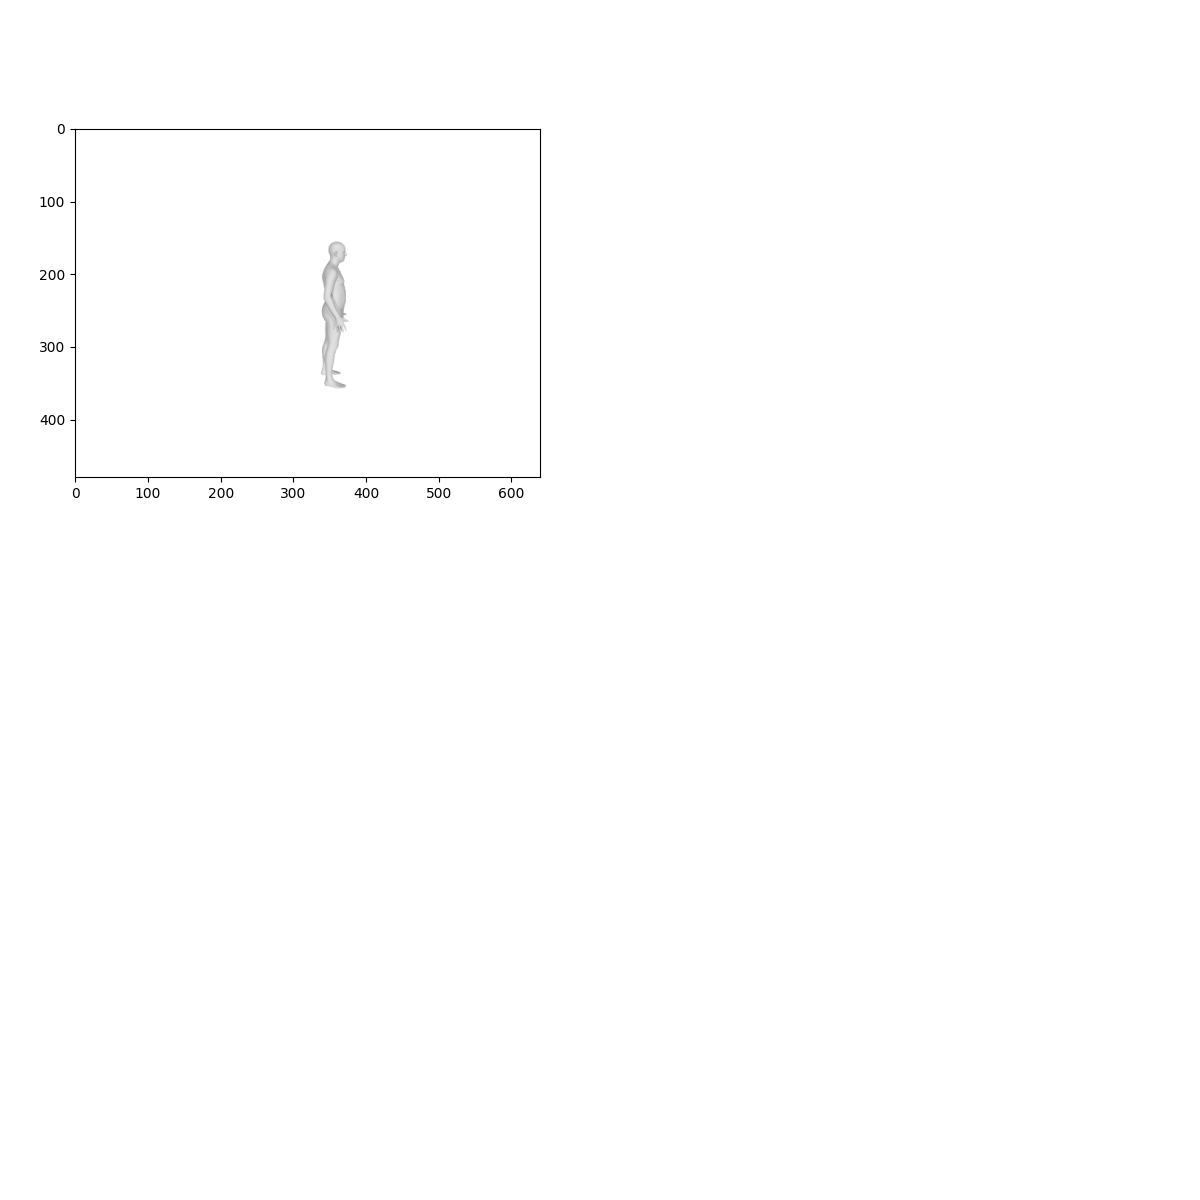

In [11]:
%matplotlib notebook

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

plot_mesh(fig, ax, mv, body.v, faces, num_verts)

### Rotate the global root orientation & translation

In [12]:
# change axis-angle of global root ration to euler
euler = R.from_rotvec(poses[:, :3]).as_euler('xyz', degrees=True)

# rotate the root so that body can face you always.
rot_angle = -euler[0, 2] # you can put any random value in here to rotate the human body randomly.
rot_euler = copy.deepcopy(euler)
rot_euler[:, 2] = euler[:, 2] + rot_angle
rot_root_orient = R.from_euler('xyz', rot_euler, degrees=True).as_rotvec()

# calculate how much you rotated root
rotmat = R.from_euler('z', -rot_angle, degrees=True).as_matrix()

# make trans start from [0, 0] and rotate it also.
rot_trans = copy.deepcopy(np.asarray(trans))
rot_trans[:, :2] = rot_trans[:, :2] - rot_trans[0:1, :2]
rot_trans = np.matmul(rot_trans, rotmat)

### Define the body model for the rotated root

In [13]:
rot_body_params = {'root_orient': torch.Tensor(rot_root_orient),
                   'pose_body': torch.Tensor(poses[:, 3:66]),
                   'trans': torch.Tensor(rot_trans),
                   }
    
rot_body = bm(**{k:v.to(device) for k,v in rot_body_params.items() if k in ['pose_body', 
                                                                            'root_orient',
                                                                            'trans'
                                                                            ]})

### do the plot of rotated body

<IPython.core.display.Javascript object>


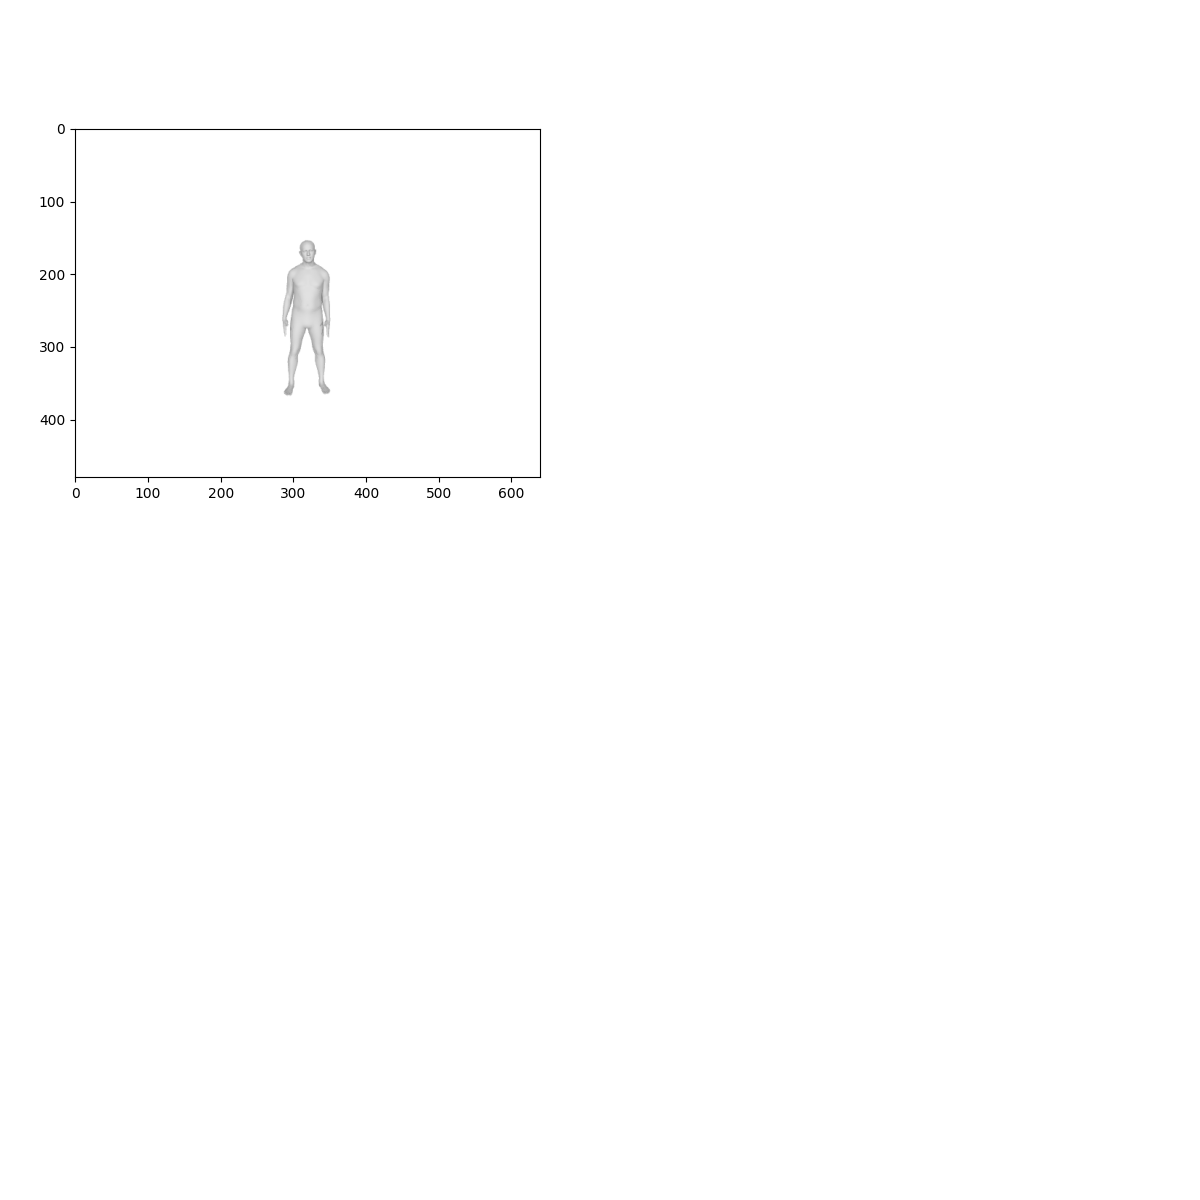

In [14]:
%matplotlib notebook

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

plot_mesh(fig, ax, mv, rot_body.v, faces, num_verts)

### Augment the body mesh (random edge cut, random shorten/lengten) and plot it
- refer to utils.transform for more detail

In [31]:
aug_pose, aug_trans = transform(np.concatenate([rot_root_orient, poses[:, 3:66]], axis=-1),
                                rot_trans, coef=4)
aug_body_params = {'root_orient': torch.Tensor(aug_pose[:, :3]),
                  'pose_body': torch.Tensor(aug_pose[:, 3:66]),
                  'trans': torch.Tensor(aug_trans),
                     }

aug_body = bm(**{k:v.to(device) for k,v in aug_body_params.items() if k in ['pose_body', 
                                                                            'root_orient',
                                                                            'trans'
                                                                            ]})

<IPython.core.display.Javascript object>


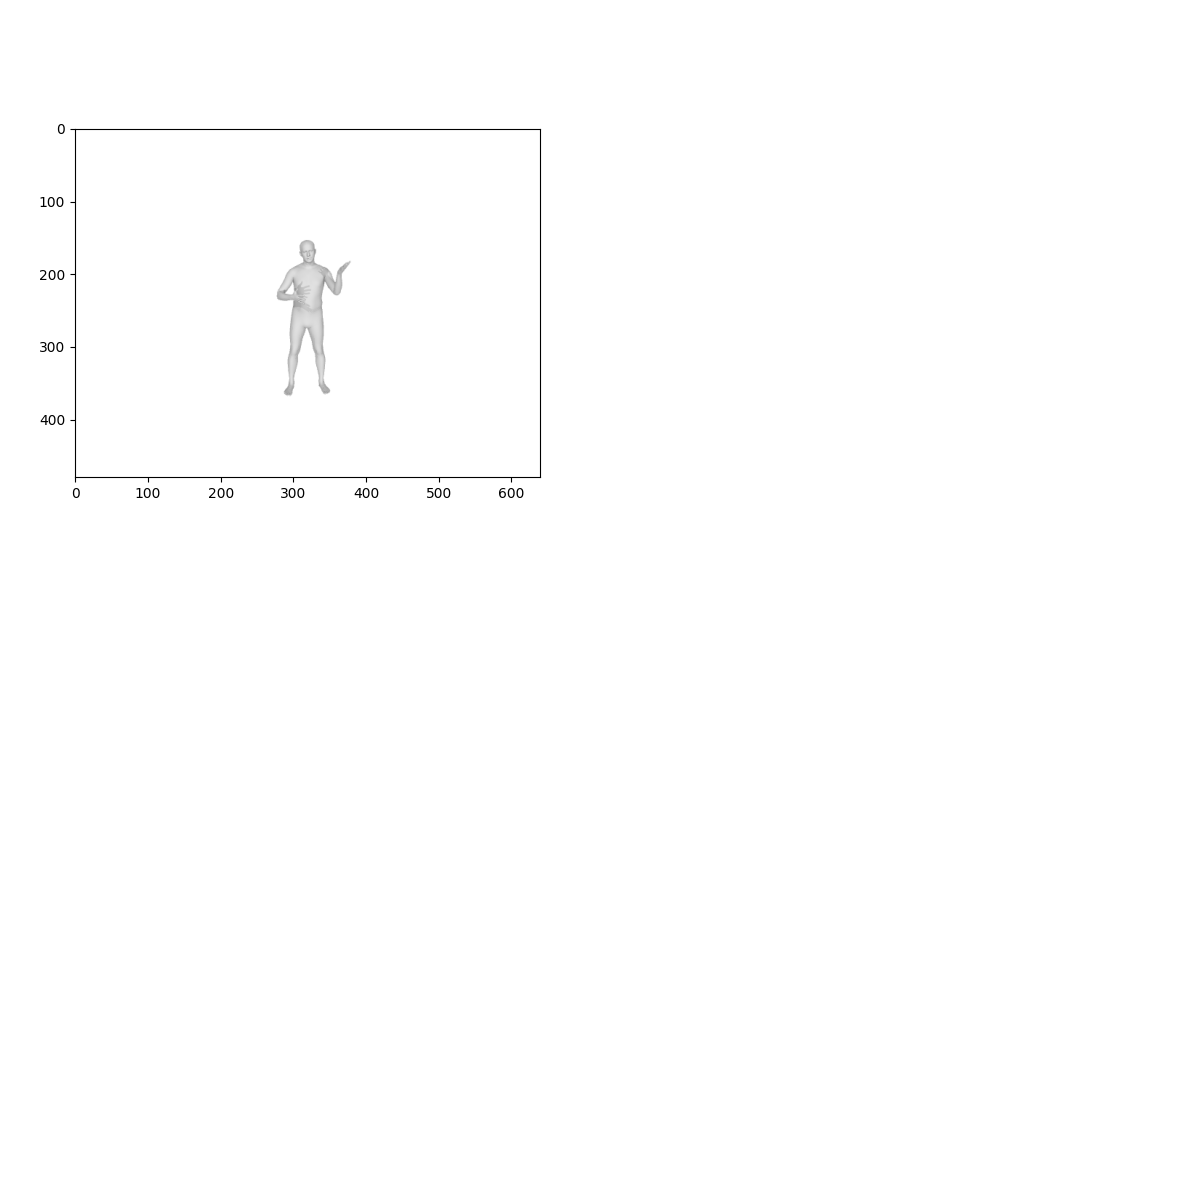

In [ ]:
%matplotlib notebook

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
plot_mesh(fig, ax, mv, aug_body.v, faces, num_verts)